## Interactive model tester
This allows interactive use of a saved Estimator model against systems configured for the **formal-test-set**.

In [105]:
from pathlib import Path
import json
import re

import numpy as np
import astropy.units as u
from astropy.time import Time
from lightkurve import LightCurve, FoldedLightCurve

%matplotlib widget 
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec

# Support for interactive widgets
from IPython.display import *
from ipywidgets import *

from ebop_maven.libs import lightcurve, deb_example, jktebop
from ebop_maven import datasets
from ebop_maven.estimator import Estimator

#### Create our Estimator

In [106]:
model_path = Path.cwd() / "drop" / "cnn_ext_model.keras"
estimator = Estimator(model=model_path)

Estimator loading model file '/home/steveo/projects/main/ebop_maven/drop/cnn_ext_model.keras'...
Loaded 'CNN-Ext-Estimator-New' last modified at 2024-04-17T18:25:36.534503.
	Inputs: [(None, 1024, 1), (None, 2, 1)]
	Outputs: (None, 6)


#### Target selection

In [107]:
targets_config_file = Path.cwd() / "config" / "formal-test-dataset.json"
with open(targets_config_file, mode="r", encoding="utf8") as cf:
    targets_cfg = json.load(cf)

target_selection = Dropdown(options=[t for t in targets_cfg], value="CW Eri")
display(target_selection)

Dropdown(index=13, options=('V436 Per', 'V539 Ara', 'psi Cen', 'V402 Lac', 'V1229 Tau', 'V889 Aql', 'WW Aur', …

#### Ingest the target assets

In [108]:
target = target_selection.get_interact_value()
target_cfg = targets_cfg[target]
sectors = [int(s) for s in target_cfg["sectors"].keys() if s.isdigit()]

# This will download and cache the timeseries fits files
fits_dir = Path.cwd() / "cache" / re.sub(r'[^\w\d-]', '_', target.lower())
lightcurve.find_lightcurves(target, fits_dir, sectors,
                            mission = target_cfg.get("mission", "TESS"),
                            author=target_cfg.get("author", "SPOC"),
                            exptime=target_cfg.get("exptime", None))

Searching for lightcurves based on; target=CW Eri, sectors=[31], mission=TESS, author=SPOC and exptime=None
Looking for previously downloaded fits within /home/steveo/projects/main/ebop_maven/cache/cw_eri
Found 2 existing fits matching mission and author criteria
Found the required 1 fits also meeting the sectors & exptime criteria. Will load the requested lightcurves from these.


LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 98853987" SECTOR=31 AUTHOR=SPOC FLUX_ORIGIN=sap_flux>

In [109]:
sectors_data = []          # Will hold the LC data to be fitted with JKTEBOP

for sector in sectors:
    sector_cfg = datasets.sector_config_from_target(sector, target_cfg)

    # These are mandatory, so error if missing
    labels = sector_cfg["labels"]
    period = sector_cfg["period"] * u.d
    pe = sector_cfg["primary_epoch"]

    # The basic light-curve data read, rectified & extended with delta_mag and delta_mag_err cols
    lc = datasets.prepare_lc_for_target_sector(target, sector, sector_cfg, fits_dir, verbose=True)

    # Get the phase folded and binned mags feature
    # TODO: need to update the Estimator to publish both of these
    pe = lightcurve.to_lc_time(pe, lc)
    print(f"Creating phase normalized, folded lightcurves about", f"{pe.format} {pe} & {period}.")
    mags_bins = estimator.mags_feature_bins
    wrap_phase = deb_example.stored_mags_features[deb_example.pub_mags_key][1]
    fold_lc = lc.fold(period, pe, wrap_phase=u.Quantity(wrap_phase), normalize_phase=True)
    phases, mags = lightcurve.get_reduced_folded_lc(flc=fold_lc, num_bins=mags_bins, phase_pivot=wrap_phase)
    
    # omega & ecc are not used as labels but we may need them for phiS
    ecosw, esinw = labels["ecosw"], labels["esinw"]
    omega = sector_cfg.get("omega", None) or np.rad2deg(np.arctan(np.divide(esinw, ecosw))) if ecosw else 0
    ecc = sector_cfg.get("ecc", None) or np.divide(ecosw, np.cos(np.deg2rad(omega))) if ecosw else 0

    # This is everything we need for this sector going forward
    sectors_data += [{
        "sector": sector,
        "file_stem": f"{re.sub(r'[^\w\d-]', '-', target.lower())}-{sector:03d}",
        "config": sector_cfg,
        "labels": labels,
        "pe": pe,
        "period": period,

        # For plots and JKTEBOP dat file
        "lc": lc,
        "fold_lc": fold_lc,
        "phases": phases,

        # For ML parameter estimatation
        "mags": mags,
        "phiS": lightcurve.expected_secondary_phase(labels["ecosw"], ecc),
        "dS_over_dP": lightcurve.expected_ratio_of_eclipse_duration(labels["esinw"])
    }]

Searching for lightcurves based on; target=CW Eri, sectors=[31], mission=TESS, author=SPOC and exptime=short
Looking for previously downloaded fits within /home/steveo/projects/main/ebop_maven/cache/cw_eri
Found 2 existing fits matching mission and author criteria
Found the required 1 fits also meeting the sectors & exptime criteria. Will load the requested lightcurves from these.
NaN/negative flux masks match 0 row(s).
Time range mask(s) matched a further 0 row(s).
	Generated polynomial; y = poly(x, c0 = -12.432101589922793, c1 = 7.209015883953336e-05, c2 = -9.30984102858426e-06) (sigma(fit_ydata)=5.904455e-04 mag)
Creating phase normalized, folded lightcurves about btjd 2163.057026533 & 2.728420258 d.


#### Plot the sector light-curves alongside the phase folded model

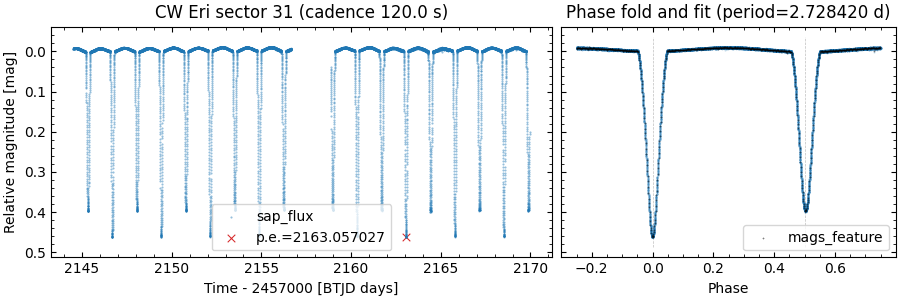

In [110]:
def plot_sector_lc_to_axes(ax: Axes, lc: LightCurve, primary_epoch: Time, title:str):
    lc.scatter(column="delta_mag", ax=ax, s=1, alpha=.5, label=lc.meta["FLUX_ORIGIN"])
    ax.set_ylabel("Relative magnitude [mag]")
    ax.set_xlabel(None if ix < rows-1 else ax.get_xlabel())
    ax.minorticks_on()
    ax.tick_params(axis="both", which="both", direction="in", bottom=True, top=True, left=True, right=True)
    ax.set_title(title)
    ax.invert_yaxis()
    if primary_epoch:
        pe, pe_mag = primary_epoch.value, lc["delta_mag"].max().value
        ax.scatter([pe], [pe_mag], zorder=-10, marker="x", s=30., lw=.75, c="tab:red", label=f"p.e.={pe:.6f}")
    ax.legend()

def plot_folded_lc_and_model_to_axes(ax: Axes, flc: FoldedLightCurve, phases, mags, title:str, mags_label:str):
    flc.scatter(column="delta_mag", ax=ax, s=1, alpha=.25, label=None)
    ax.scatter(phases, mags, c="k", alpha=.5, marker="+", s=3, lw=.5, label=mags_label)
    ax.set_ylabel(None)
    ax.set_xlabel(None if ix<rows-1 else ax.get_xlabel())
    ymin, ymax = ax.get_ylim()
    ax.vlines([0.0, 0.5], ymin, ymax, linestyles="--", color="k", lw=.5, alpha=.25)
    ax.minorticks_on()
    ax.set_title(title)
    ax.tick_params(axis="both", which="both", direction="in", bottom=True, top=True, left=True, right=True, labelleft=False)
    ax.legend()

rows = len(sectors)
fig = plt.figure(figsize=(9, 3*rows), constrained_layout=True)
gs = GridSpec(figure=fig, ncols=2, nrows=rows, width_ratios=(3, 2))
target_label = target_cfg.get("label", target)
for ix, sd in enumerate(sectors_data):
    exptime = sd["lc"].meta["FRAMETIM"] * sd["lc"].meta["NUM_FRM"] * u.s  
    ax_lc = fig.add_subplot(gs[ix, 0])
    plot_sector_lc_to_axes(ax_lc, sd["lc"], sd["pe"],
                           f"{target_label} sector {sd['sector']} (cadence {exptime})")
    ax_fold = fig.add_subplot(gs[ix, 1], sharey=ax_lc)
    plot_folded_lc_and_model_to_axes(ax_fold, sd["fold_lc"], sd["phases"], sd["mags"],
                                     f"Phase fold and fit (period={period:.6f})", "mags_feature")

#### Estimate the JKTEBOP fitting parameters

In [111]:
# An iterations value over 1 triggers the MC Dropout algorithm giving us nominal and 1-sigma values.
# The model predicts scaled values (e.g. predicting inc*0.01) which the Estimator usually ondoes,
# but here we would like the scaled values to report on model performance as model.evaluate() would.
unscale = True
instance_features = [{ f: sd[f] for f in ["mags", "phiS", "dS_over_dP"] } for sd in sectors_data]
predictions = estimator.predict(instance_features, iterations=1000, unscale=unscale)

# Copy these into sector data
for (sd, pred) in zip(sectors_data, predictions):
    sd["predictions"] = pred

# Produce some statistics on the quality of the underlying model's predictions.
label_names = [*estimator.label_names_and_scales.keys()]
scales = [*estimator.label_names_and_scales.values()]
labels = np.multiply([[sd["labels"][l] for l in label_names] for sd in sectors_data], 1 if unscale else scales)
pred_noms = np.array([[p[l] for l in label_names] for p in predictions])
pred_errs = np.array([[p[f"{l}_sigma"] for l in label_names] for p in predictions])
ocs = np.subtract(pred_noms, labels)
mae, mse = np.mean(np.abs(ocs)), np.mean(np.power(ocs, 2))

# Plot a table
cols = len(label_names)
print(f"Estimated {'un' if unscale else ''}scaled JKTEBOP input parameters for target {target}\n")
print("           |", *[f"{n:>10s}" for n in label_names + ["MAE", "MSE"]])
for sector, snoms, slabels, socs in zip(sectors, pred_noms, labels, ocs):
    socs = np.concatenate([socs, [np.mean(np.abs(socs)), np.mean(np.power(socs, 2))]])
    print("-"*100)
    for heading, vals in zip([f"S{sector:03d} Pred", "Label", "O-C"], [snoms, slabels, socs]):
        print(f"{heading:>10s} |", *[f"{v:10.6f}" for v in vals])
print("="*100)
print(f"{'MAE':>10s} |", *[f"{v:10.6f}" for v in np.mean(np.abs(ocs), axis=0)], f"{mae:10.6f}")
print(f"{'MSE':>10s} |", *[f"{v:10.6f}" for v in np.mean(np.power(ocs, 2), axis=0)], " "*10, f"{mse:10.6f}")

Estimated unscaled JKTEBOP input parameters for target CW Eri

           | rA_plus_rB          k          J      ecosw      esinw        inc        MAE        MSE
----------------------------------------------------------------------------------------------------
 S031 Pred |   0.355057   0.987826   0.937460   0.005439  -0.004081  84.833122
     Label |   0.306620   0.703700   0.926200   0.005020  -0.012100  86.381000
       O-C |   0.048437   0.284126   0.011260   0.000419   0.008019  -1.547878   0.316690   0.413198
       MAE |   0.048437   0.284126   0.011260   0.000419   0.008019   1.547878   0.316690
       MSE |   0.002346   0.080728   0.000127   0.000000   0.000064   2.395926              0.413198


#### Perform JKTEBOP fitting on the target's sectors
The parameter estimated above are now used as a starting point for JTEBOP task 3 fitting.

In [112]:
jktebop_dir = jktebop.get_jktebop_dir()

for sd in sectors_data:
    # JKTEBOP won't overwrite files so make sure we clear down anything which could cause trouble
    file_stem = sd["file_stem"]
    for file in jktebop_dir.glob(f"{file_stem}.*"):
        file.unlink()

    in_filename = jktebop_dir / f"{file_stem}.in"
    dat_filename = jktebop_dir / f"{file_stem}.dat"
    params = {
        "qphot": 0.,
        "gravA": 0.,        "gravB": 0.,
        "L3": 0.,
        "LDA": "quad",      "LDB": "quad",
        "LDA1": 0.25,       "LDB1": 0.25,
        "LDA2": 0.22,       "LDB2": 0.22,
        "reflA": 0.,        "reflB": 0.,
        "period": sd["period"].to(u.d).value,
        "primary_epoch": sd["pe"].value,

        "ecosw_fit": 1,     "esinw_fit": 1,
        "L3_fit": 1,
        "LDA1_fit": 1,      "LDB1_fit": 1,
        "LDA2_fit": 0,      "LDB2_fit": 0,
        "data_file_name": dat_filename.name,
        "file_name_stem": file_stem,

        # Now apply the predictions over the default params
        **sd["predictions"],
    }

    # TODO: auto scaling poly instructions
    poly_lines = []

    jktebop.write_in_file(in_filename, task=3, append_lines=poly_lines, **params)
    jktebop.write_light_curve_to_dat_file(sd["lc"], dat_filename,
                                        column_formats=[lambda t: f"{t.value:.6f}", "%.6f", "%.6f"])
    
    # Don't consume the output files so they're available for subsequent plotting
    print(f"\nFitting {target} sector {sd['sector']:03d} with JKTEBOP task 3...")
    out_filename = jktebop_dir / f"{file_stem}.par"
    sd["out_params"] = list(jktebop.run_jktebop_task(in_filename, out_filename, stdout_capture=print))



Fitting CW Eri sector 031 with JKTEBOP task 3...

JKTEBOP  v44  John Southworth (Keele University, UK, taylorsouthworth~gmail.com)
Task 3  finds the best fit of the model to observations  (formal errorbars only)
>> Opened new parameter  file:  cw-eri-031.par
>> Opened new LC output  file:  cw-eri-031.out
>> Opened new model fit  file:  cw-eri-031.fit
>> Read  16671 datapoints (with errors) from file cw-eri-031.dat
>> Best fit has been found after 62 iterations.



#### Review the JKTEBOP fitting results

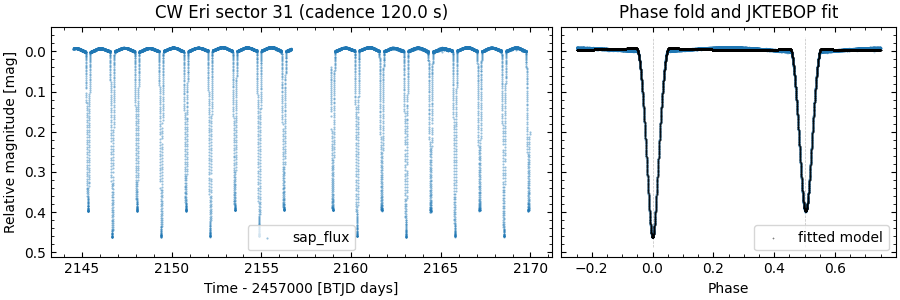

In [113]:
jktebop_dir = jktebop.get_jktebop_dir()
rows = len(sectors)
fig = plt.figure(figsize=(9, 3*rows), constrained_layout=True)
gs = GridSpec(figure=fig, ncols=2, nrows=rows, width_ratios=(3, 2))
target_label = target_cfg.get("label", target)

for ix, sd in enumerate(sectors_data):
    with open(jktebop_dir / f"{sd['file_stem']}.fit", mode="r", encoding="utf8") as ff:
        fit_data =  np.loadtxt(ff, usecols=(0, 1), comments="#", dtype=np.double, unpack=True)
        fit_data[0][fit_data[0]>0.75] -= 1.

    exptime = sd["lc"].meta["FRAMETIM"] * sd["lc"].meta["NUM_FRM"] * u.s  
    ax_lc = fig.add_subplot(gs[ix, 0])
    plot_sector_lc_to_axes(ax_lc, sd["lc"], None, f"{target_label} sector {sd['sector']} (cadence {exptime})")
    ax_fold = fig.add_subplot(gs[ix, 1], sharey=ax_lc)
    plot_folded_lc_and_model_to_axes(ax_fold, sd["fold_lc"], fit_data[0], fit_data[1],
                                     f"Phase fold and JKTEBOP fit", "fitted model")